Import libraries:

In [11]:
from scipy.stats.stats import pearsonr 
from statistics import median
import statsmodels.api as sm 
import statistics

import pandas as pd
import numpy as np
import warnings

import quandl
import datetime
import pandas_datareader as web

import matplotlib.pyplot as plt
import matplotlib.dates as dates
from functools import reduce

warnings.filterwarnings('ignore')

Parameters:

In [12]:
# weeks per year
scale = 56
test_hor = 2*scale

# start and end dates
start_date = datetime.datetime(2000,1,1)
end_date = datetime.datetime(2020,3,1)

# list of assets
asset_list = ['SPY','TLT','GOLD','IYR']

Custom functions:

In [13]:
def wrd_div(n, d):
    return n / d if d else 0

Read Adj.Close through Yahoo Finance:

In [14]:
df_list = []

for i in range(len(asset_list)):
    df_list.append(web.get_data_yahoo(asset_list[i], start=start_date, end=end_date)[['Adj Close']])

df = reduce(lambda left,right: pd.merge(left, right, on=['Date'], how='inner'), df_list)
df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='W-FRI'))

df = df.dropna(how='any', axis=0)
df.columns = asset_list
df.head()

,SPY,TLT,GOLD,IYR
2002-08-02,61.091061,44.533382,6.458117,18.769566
2002-08-09,64.258560,45.080460,6.577331,18.645432
2002-08-16,65.617096,45.175999,6.462229,19.111504
2002-08-23,66.588455,45.622166,6.084032,19.146643
2002-08-30,64.603523,46.248894,6.606106,19.530746


Data properties:

In [15]:
print('Number of records:', len(df))
print('Start date:', str(df.index[0])[:11])
print('End date:', str(df.index[-1])[:11])

Number of records: 889
Start date: 2002-08-02 
End date: 2020-02-28 


Metrics vice horizon:

In [16]:
df_stat, df_hor, cor = [],[],[]
p_med, p_std, p_var = [],[],[]
ass_ret, ass_std, ass_var = [],[],[]

for i in range(test_hor): 
    
    df_hor.append(i/scale)
    df_ret = 100*df.pct_change(periods=i).dropna()
    v = df_ret[df_ret <= 0].apply(lambda x : x.abs().quantile(0.95))
    
    p_ret = (1/len(df_ret.columns))*df_ret.sum(axis = 1, skipna = True)
    
    p_med.append(p_ret.median())
    p_std.append(p_ret.std())
    p_var.append(np.quantile(([abs(x) for x in p_ret if x <= 0]), 0.95))

    cor.append(pearsonr(list(df_ret['SPY']),list(p_ret))[0])
    
    df_stat.append(pd.DataFrame({'Return': df_ret.median(), 'Standard': df_ret.std(), 'Value at risk': v}))
    
print('Portfolio vice SP500 correlation:', round(np.median(cor[1:]),2))  

Portfolio vice SP500 correlation: 0.52


Value at risk (95%), median return vice horizon:

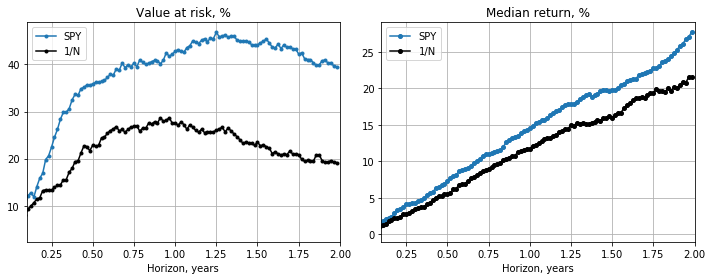

In [20]:
metrics_list = ['Return', 'Standard', 'Value at risk']

for item in range(len(df.columns)):  
    ass_ret.append(list([float(df_stat[x]['Return'].iloc[item]) for x in range(test_hor)]))
    ass_std.append(list([float(df_stat[x]['Standard'].iloc[item]) for x in range(test_hor)]))
    ass_var.append(list([float(df_stat[x]['Value at risk'].iloc[item]) for x in range(test_hor)]))  

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)

plt.plot(df_hor[1:], ass_var[0][1:], '.-', label=asset_list[0])
plt.plot(df_hor[1:], p_var[1:], '.-', label='1/N', color='black')

plt.title('Value at risk, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.xlim(0.1,2)
plt.grid(True)

plt.subplot(1, 2, 2)

plt.plot(df_hor[1:], ass_ret[0][1:], '.-',  markersize=8, label=asset_list[0])   
plt.plot(df_hor[1:], p_med[1:], '.-', markersize=8, label='1/N', color='black')

plt.title('Median return, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.xlim(0.1,2)
plt.grid(True)

plt.tight_layout()

Return/Var:

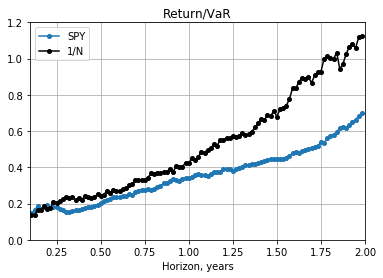

In [18]:
z = [wrd_div(x,y) for x, y in zip(ass_ret[0][1:], ass_var[0][1:])]
plt.plot(df_hor[1:], z[:], '.-',  markersize=8, label=asset_list[0])

t = [wrd_div(x,y) for x, y in zip(p_med[1:], p_var[1:])]
    
plt.plot(df_hor[1:], t[:], '.-', markersize=8, label='1/N', color='black')
plt.xlabel('Horizon, years')    
    
plt.title('Return/VaR')
plt.xlabel('Horizon, years')

plt.xlim(0.1,2)
plt.ylim(0,1.2)

plt.legend(loc='upper left')
plt.grid(True)

plt.show()

Plot cumulated return vice holding period:

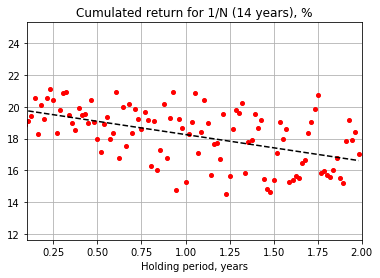

In [19]:
years_num = int(round(len(df)/scale))
df_cum = pd.DataFrame(round(100*(df.iloc[-1]-df.iloc[0])/df.iloc[0]))
df_annual = (df_cum.transpose()/years_num).astype('int64')

p_cum, p_hor = [], []

for i in range(1, test_hor):
    
    df_p = df.iloc[::i].apply(np.log).diff(periods=1).dropna(axis = 0)
    df_p = 0.25*df_p.sum(axis=1)
    df_p = 100*(df_p+1).product()-1
    df_p = df_p/years_num
    
    p_hor.append(i/scale)
    p_cum.append(df_p)

plt.plot(p_hor, p_cum, '.', markersize=8, color='red')

x,y = np.unique(p_hor), np.poly1d(np.polyfit(p_hor, p_cum, 1))
plt.plot(x, y(x), '--', color='black')

plt.xlim(0.1,2)
plt.ylim(0.8*min(p_cum), 1.2*max(p_cum))

plt.xlabel('Holding period, years')
plt.title('Cumulated return for 1/N (14 years), %')

plt.grid(True)
plt.show()